# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

Loaded final dataset with shape: (256101, 19)
Columns: ['system_calendar_key_n', 'product_id', 'sales_dollars_value', 'sales_units_value', 'sales_lbs_value', 'date', 'week', 'year', 'claim_id', 'searchvolume', 'searchvolume_lag2', 'searchvolume_lag3', 'searchvolume_lag6', 'searchvolume_lag11', 'total_post', 'posts_lag2', 'posts_lag3', 'posts_lag6', 'posts_lag11']

===== Defining features and target =====
Model dataset shape after selecting features: (256101, 15)
Number of outliers in target variable: 29360
Model dataset shape after removing outliers: (226741, 15)


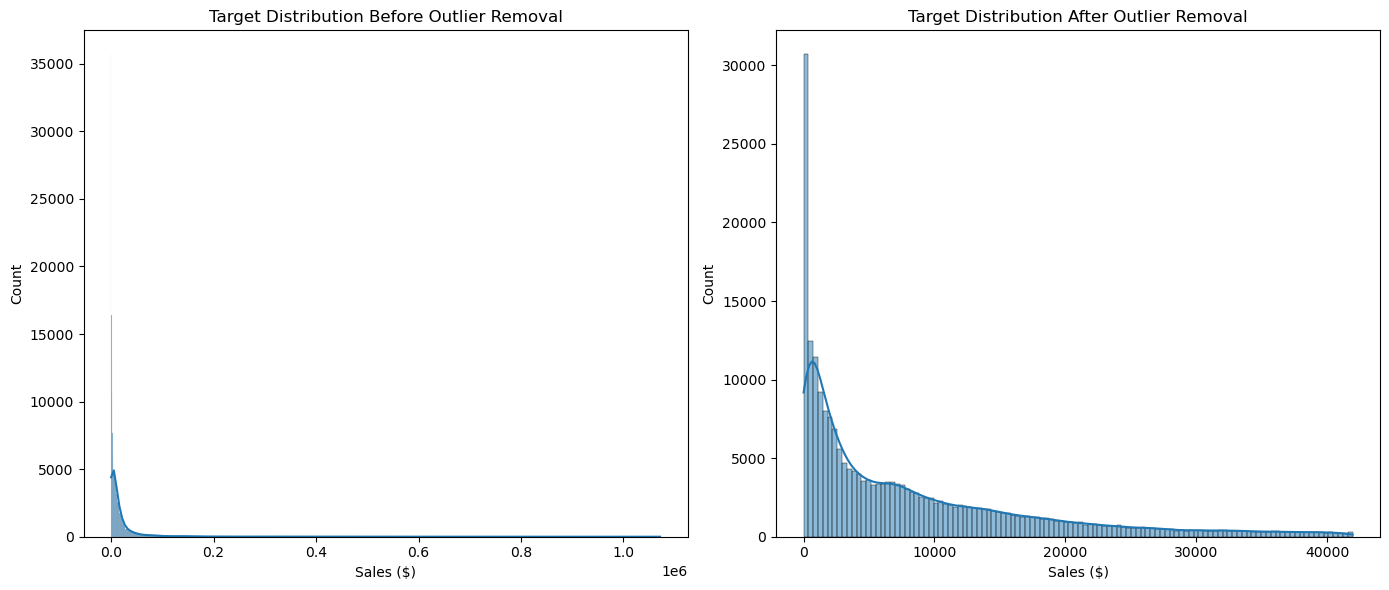


===== Applying Box-Cox transformation to numeric features =====


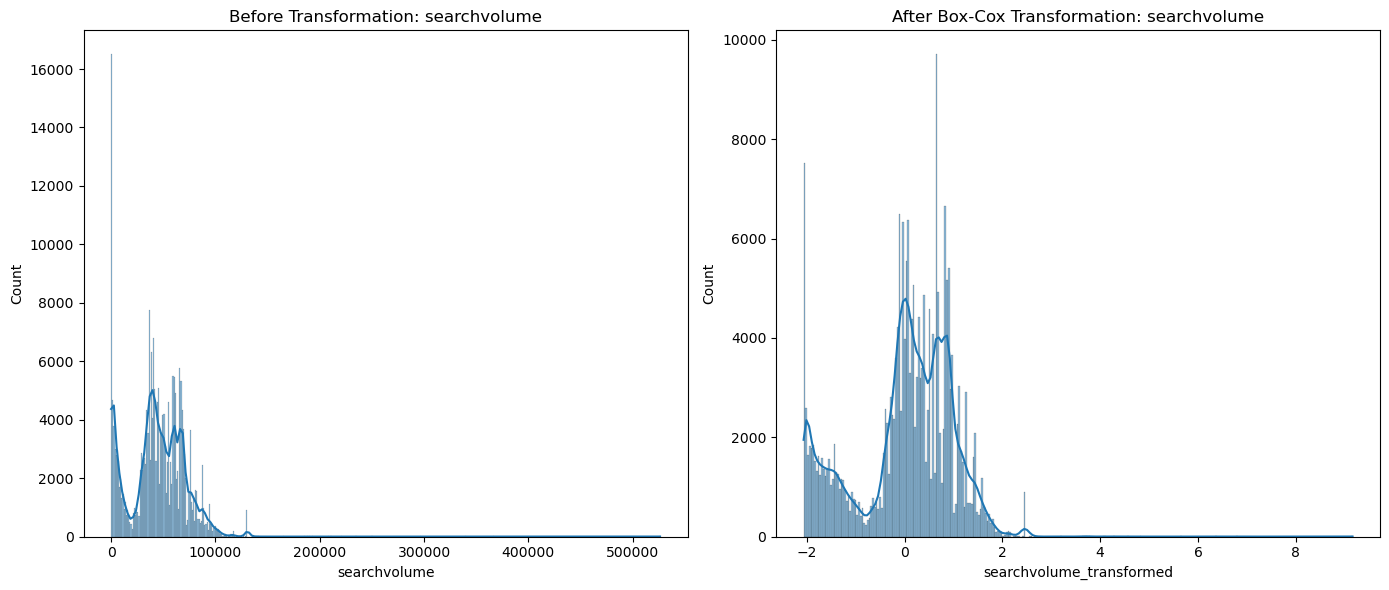

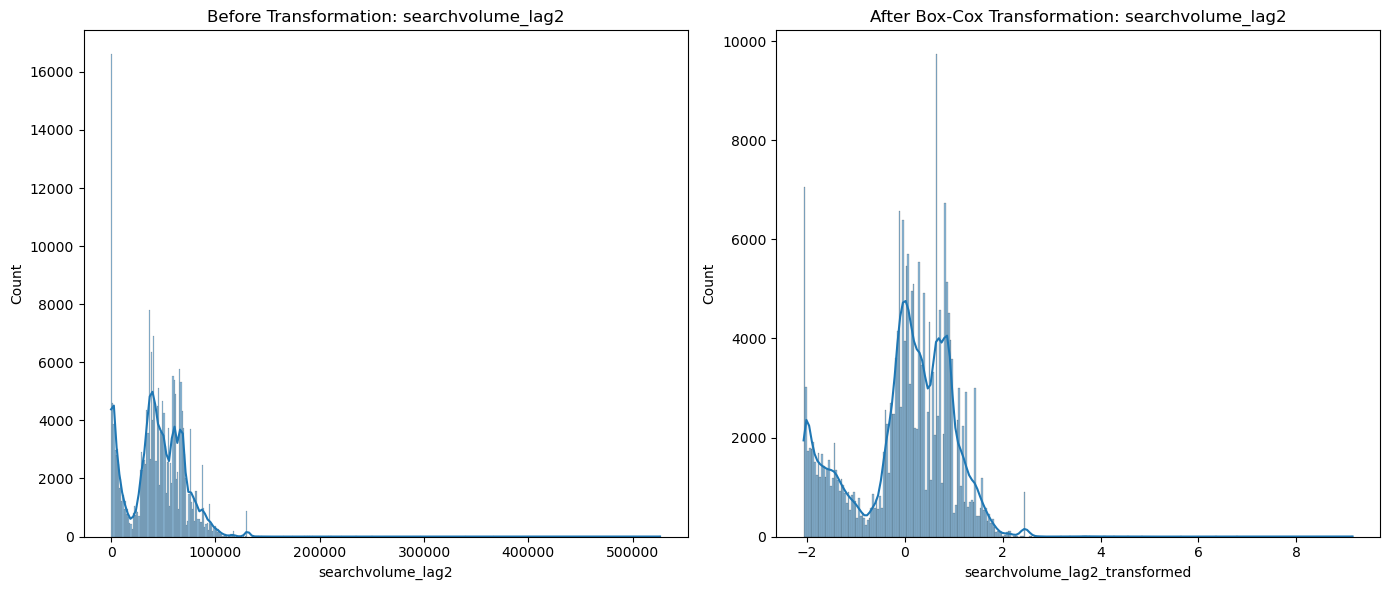

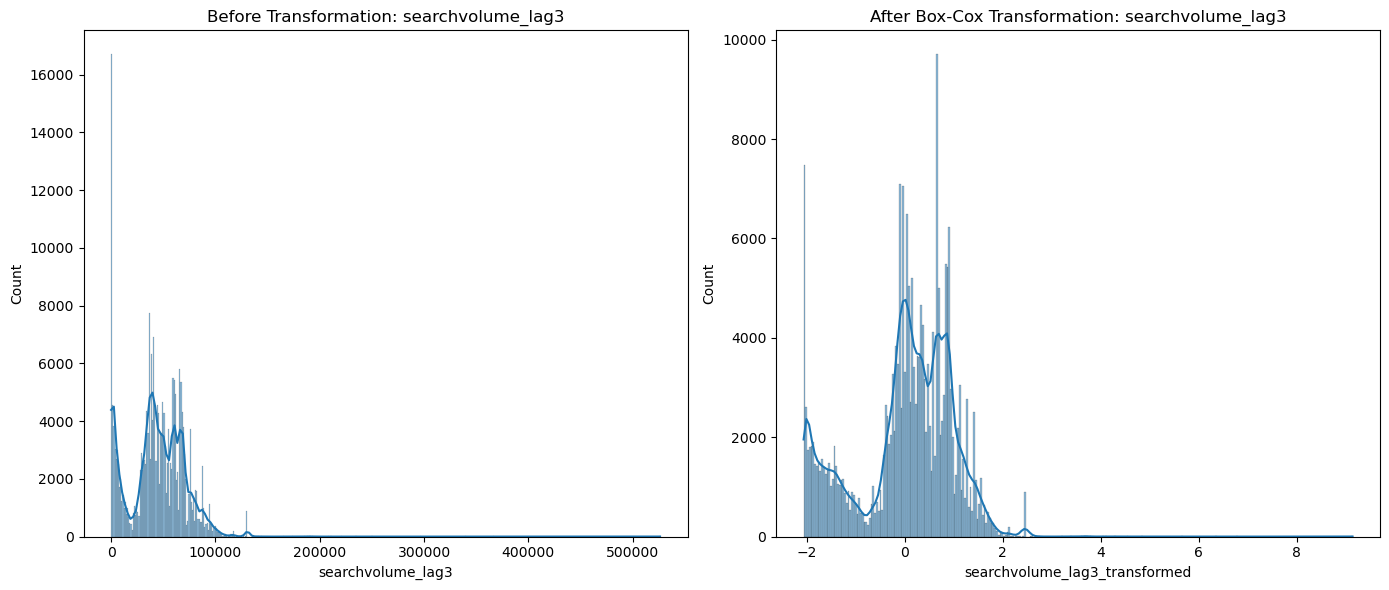

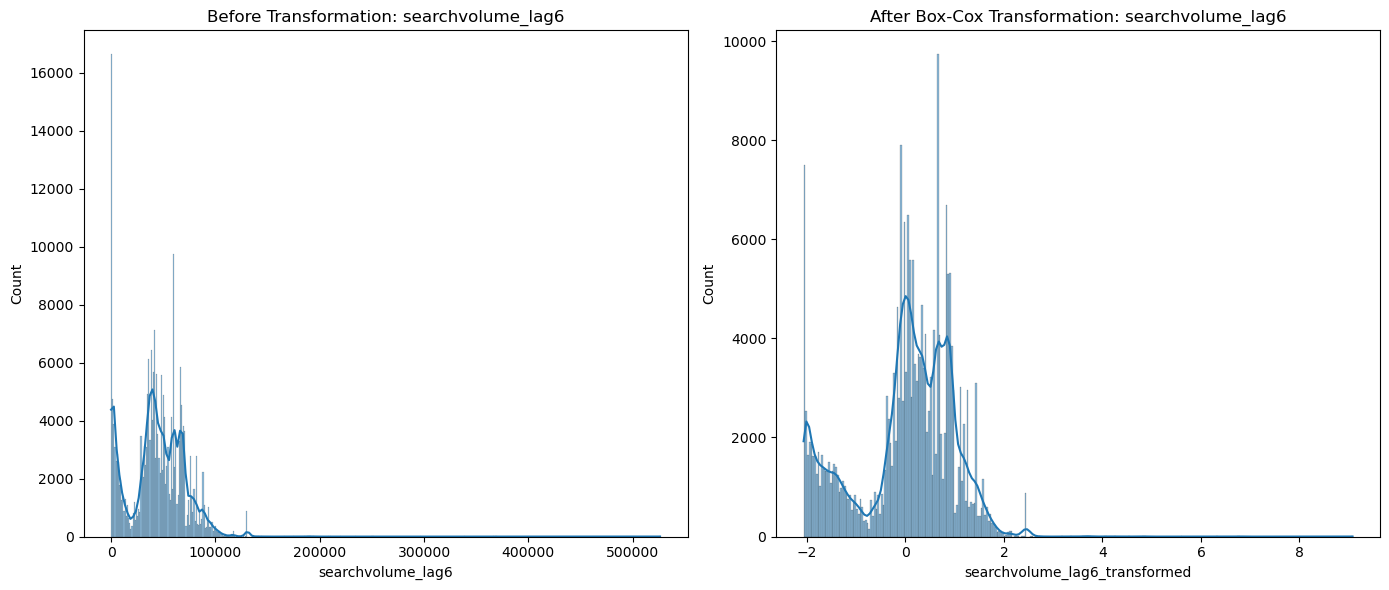

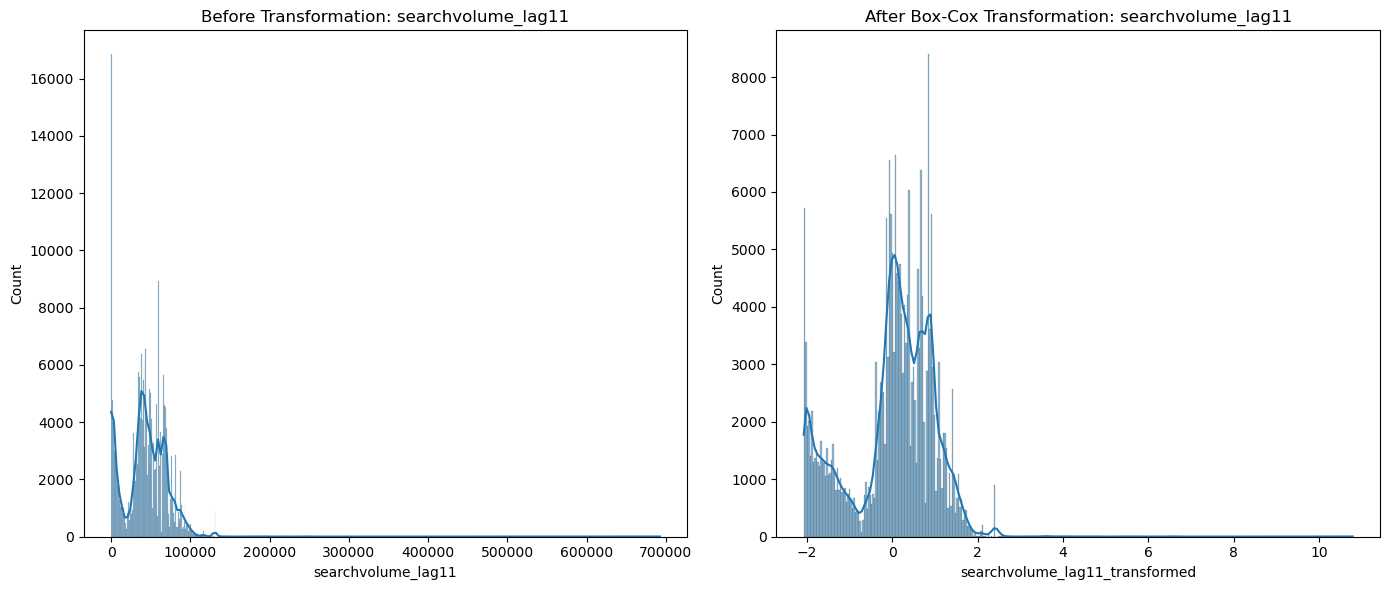

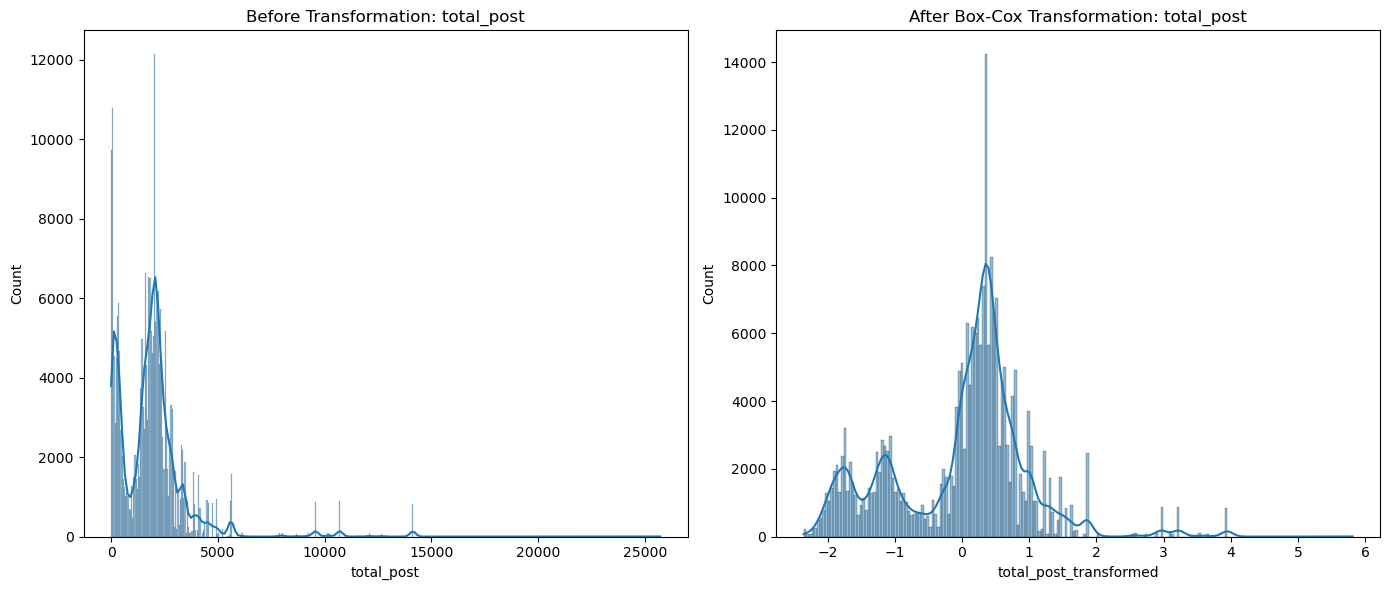

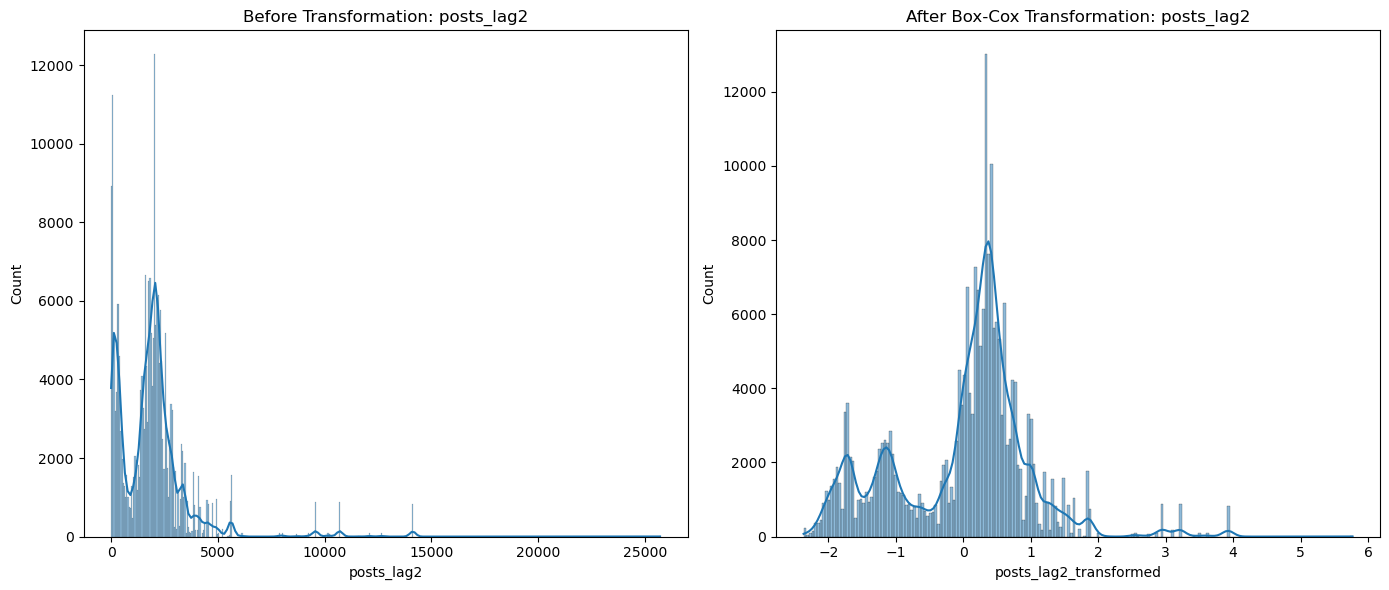

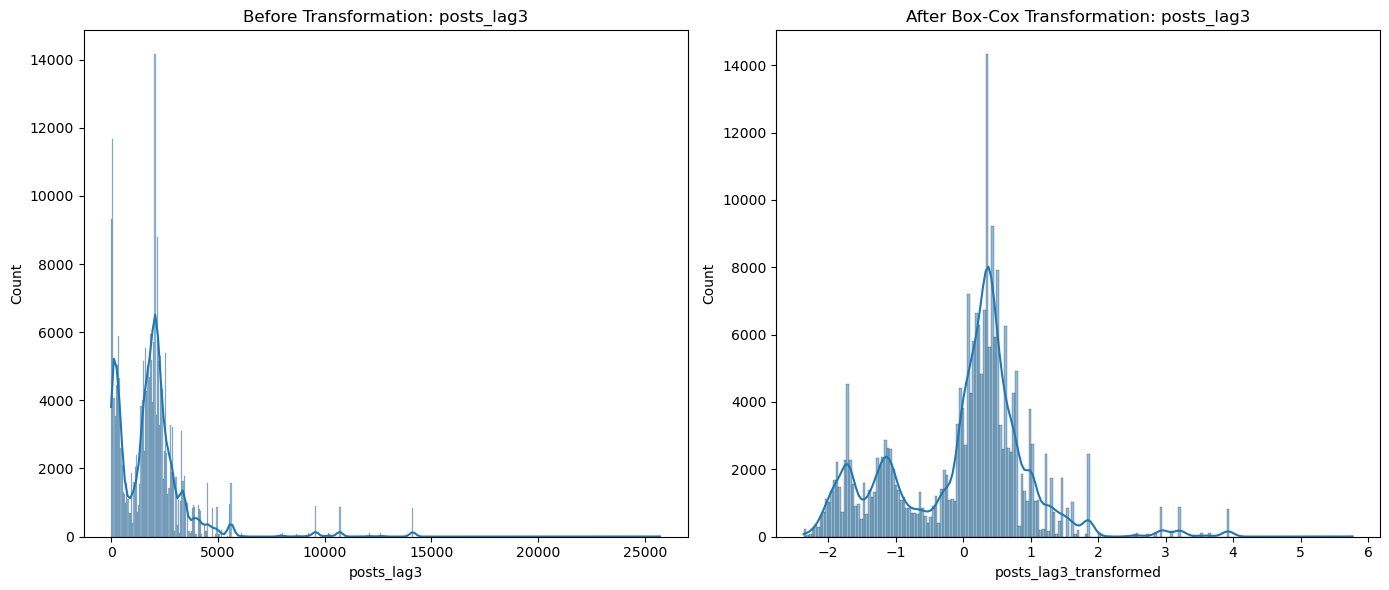

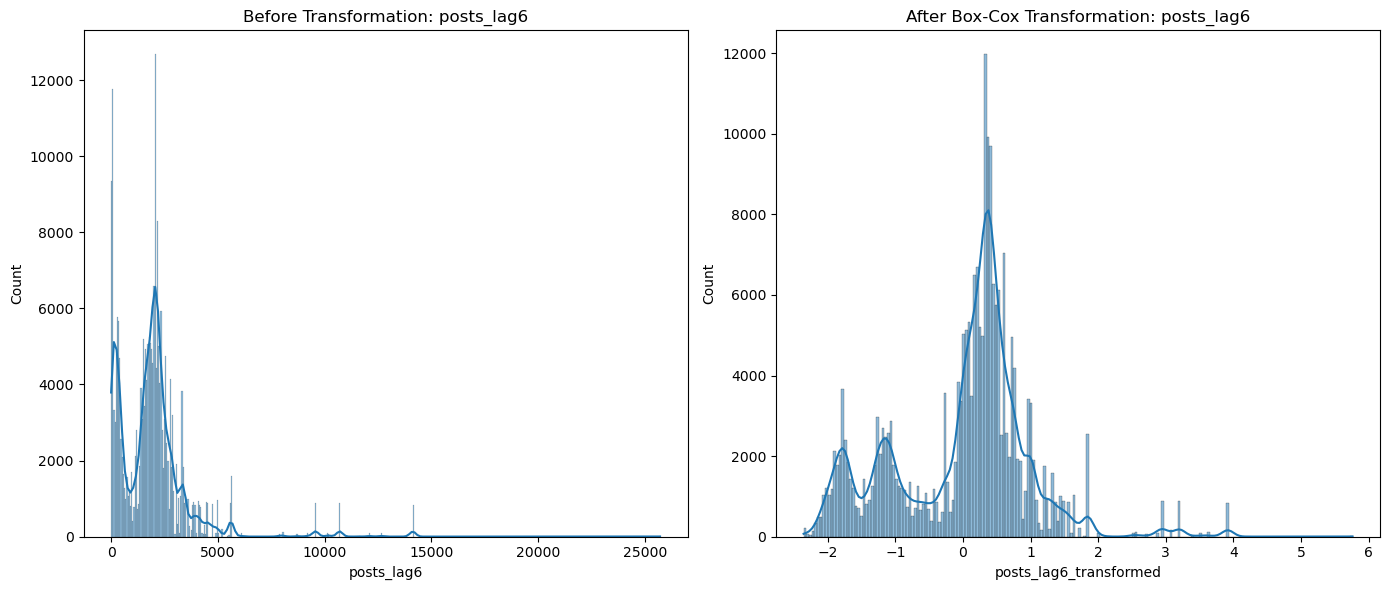

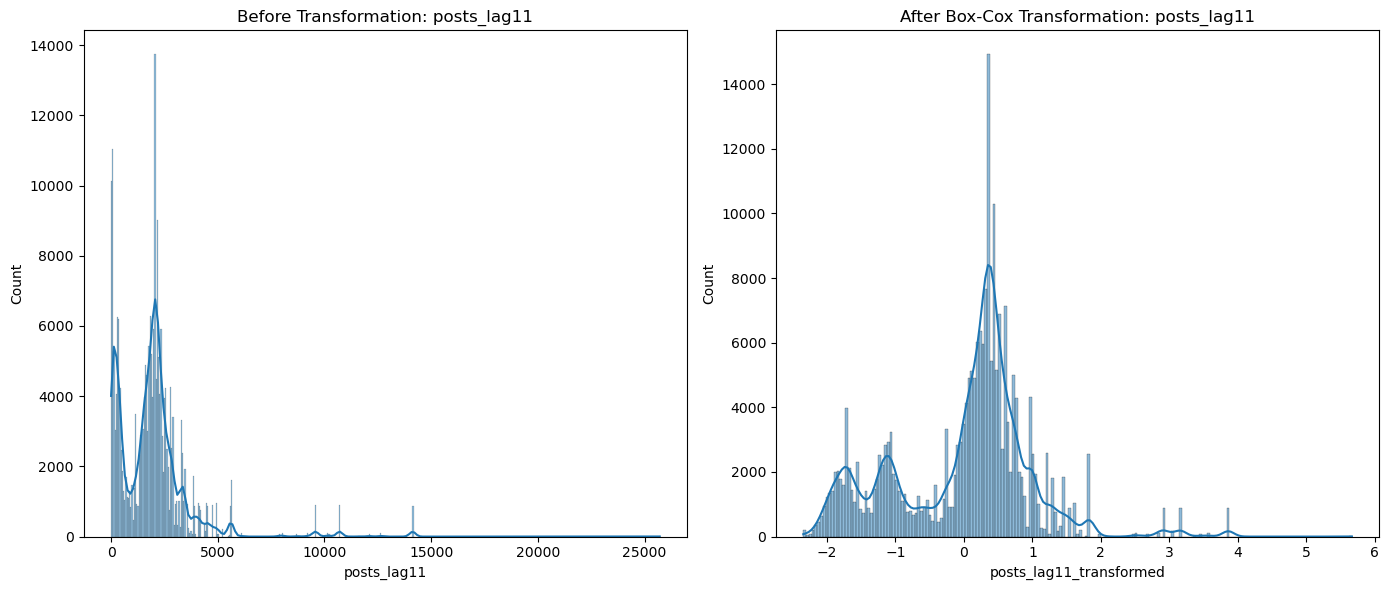


===== Splitting data into train and test sets =====
Training set: 181392 samples
Test set: 45349 samples

===== Hyperparameter tuning with GridSearchCV =====
Fitting 5 folds for each of 36 candidates, totalling 180 fits


/home/ritam/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ritam/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ritam/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/ritam/miniforge3/envs/ta-lib-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and wi

Best parameters: {'depth': 8, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Best cross-validation score: 0.6492

===== Training final model with best parameters =====


0:	learn: 8862.0840759	test: 8841.8812899	best: 8841.8812899 (0)	total: 147ms	remaining: 1m 13s
50:	learn: 5186.8532100	test: 4904.6265411	best: 4904.6265411 (50)	total: 4.06s	remaining: 35.8s
100:	learn: 4910.5940996	test: 4630.0184841	best: 4630.0184841 (100)	total: 9.17s	remaining: 36.2s
150:	learn: 4742.6006747	test: 4463.8516279	best: 4463.8516279 (150)	total: 14.6s	remaining: 33.8s
200:	learn: 4597.9003920	test: 4331.6217651	best: 4331.6217651 (200)	total: 21s	remaining: 31.2s
250:	learn: 4455.2127575	test: 4201.6143518	best: 4201.6143518 (250)	total: 26s	remaining: 25.8s
300:	learn: 4339.4855194	test: 4098.3927795	best: 4098.3927795 (300)	total: 31s	remaining: 20.5s
350:	learn: 4247.9972344	test: 4013.4535584	best: 4013.4535584 (350)	total: 36.2s	remaining: 15.4s
400:	learn: 4181.3832034	test: 3954.7275857	best: 3954.7275857 (400)	total: 42.3s	remaining: 10.4s
450:	learn: 4113.1859852	test: 3893.8518485	best: 3893.8518485 (450)	total: 48.1s	remaining: 5.23s
499:	learn: 4054.5787

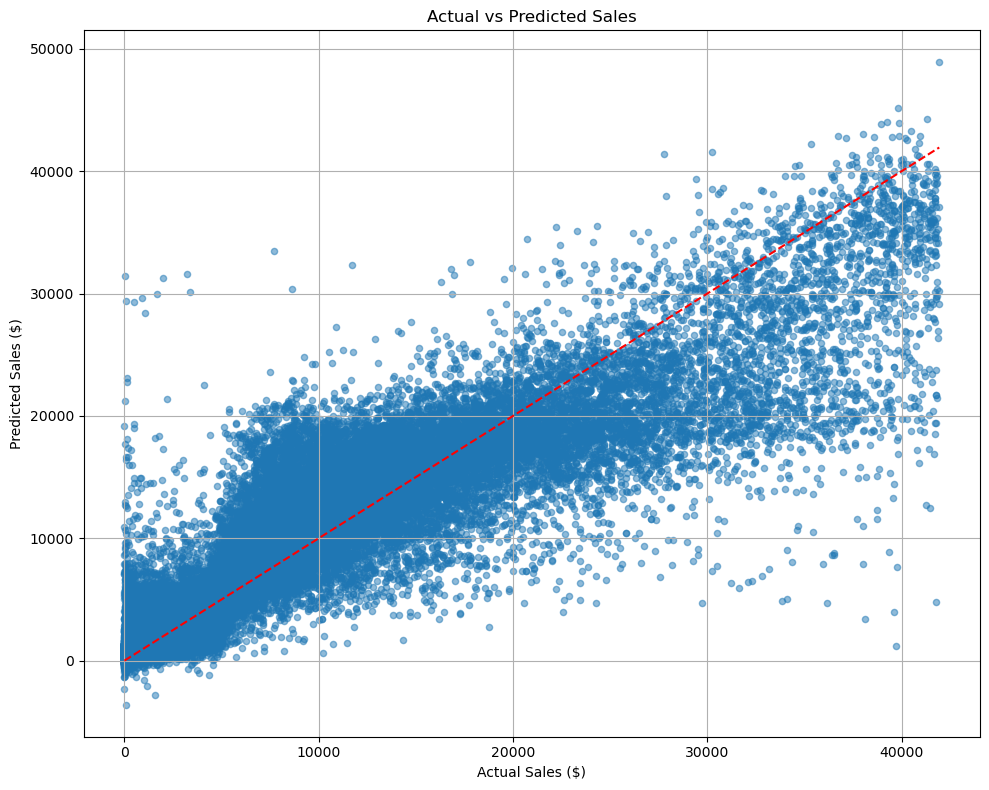

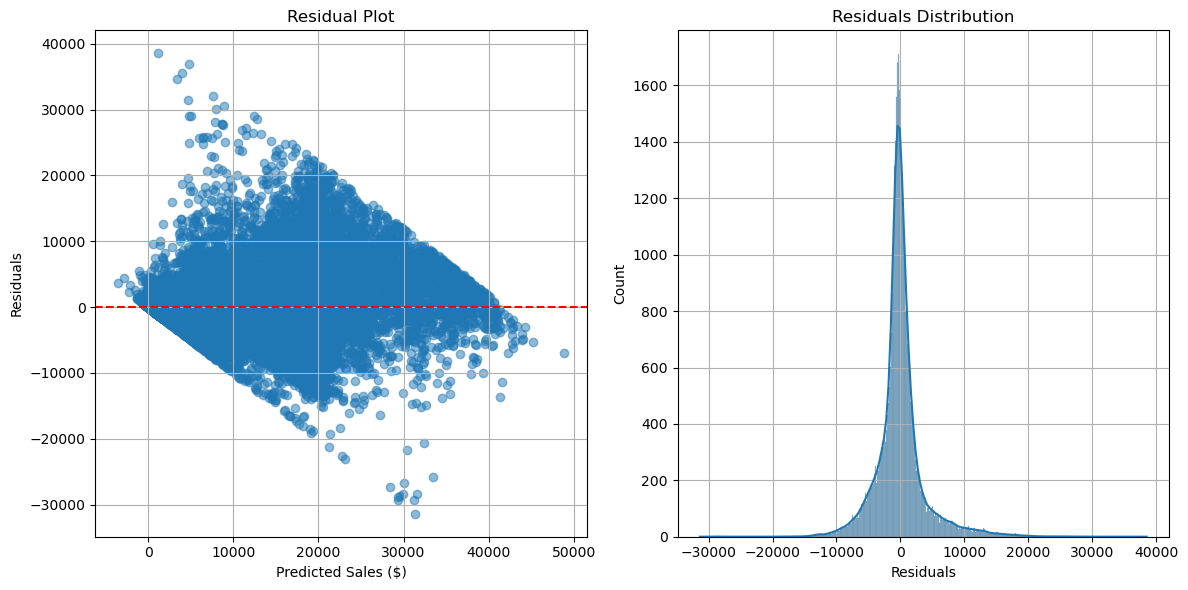

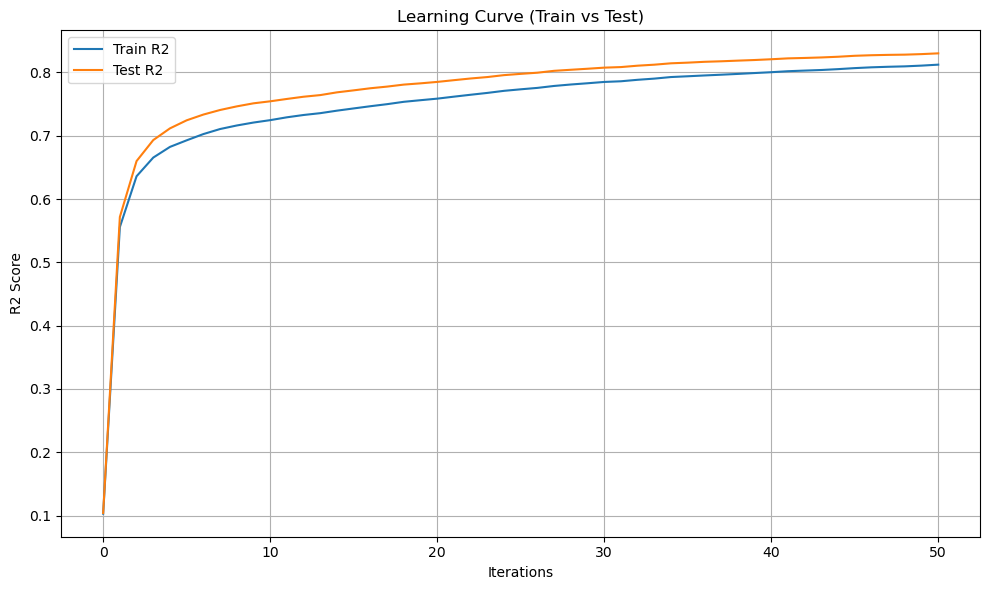

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

In [2]:
# Model Training and Evaluation Notebook
# -------------------------------------

import os
import os.path as op
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_absolute_percentage_error, mean_squared_error
from sklearn.preprocessing import PowerTransformer
import shap
import warnings
warnings.filterwarnings('ignore')

# Load the preprocessed data
processed_folder = op.join('data', 'processed')
final_df = pd.read_parquet(op.join(processed_folder, 'final_model_data.parquet'))

print(f"Loaded final dataset with shape: {final_df.shape}")
print(f"Columns: {final_df.columns.tolist()}")

# Define model outputs directory
model_output_dir = op.join('models')
os.makedirs(model_output_dir, exist_ok=True)

# Step 1: Define features and target
print("\n===== Defining features and target =====")
categorical_features = ['product_id', 'week', 'year', 'claim_id']
numeric_features = ['searchvolume', 'searchvolume_lag2', 'searchvolume_lag3', 
                   'searchvolume_lag6', 'searchvolume_lag11', 
                   'total_post', 'posts_lag2', 'posts_lag3', 
                   'posts_lag6', 'posts_lag11']
target = 'sales_dollars_value'

# Step 2: Drop rows with missing values in selected columns
selected_cols = categorical_features + numeric_features + [target]
model_df = final_df[selected_cols].dropna()
print(f"Model dataset shape after selecting features: {model_df.shape}")

# Step 3: Remove outliers using IQR method (for target variable)
Q1 = model_df[target].quantile(0.25)
Q3 = model_df[target].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers_mask = (model_df[target] < lower_bound) | (model_df[target] > upper_bound)
print(f"Number of outliers in target variable: {outliers_mask.sum()}")

model_df = model_df[(model_df[target] >= lower_bound) & (model_df[target] <= upper_bound)]
print(f"Model dataset shape after removing outliers: {model_df.shape}")

# Visualize target distribution before and after outlier removal
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
sns.histplot(final_df[target], kde=True)
plt.title('Target Distribution Before Outlier Removal')
plt.xlabel('Sales ($)')

plt.subplot(1, 2, 2)
sns.histplot(model_df[target], kde=True)
plt.title('Target Distribution After Outlier Removal')
plt.xlabel('Sales ($)')

plt.tight_layout()
plt.show()

# Step 4: Apply Box-Cox transformation to numeric features
print("\n===== Applying Box-Cox transformation to numeric features =====")
transformed_features = {}

for feature in numeric_features:
    # Make sure all values are positive before applying Box-Cox
    model_df[feature] = model_df[feature] - model_df[feature].min() + 1  # Shift values to be positive
    
    # Apply Box-Cox transformation
    pt = PowerTransformer(method='box-cox')
    model_df[feature + '_transformed'] = pt.fit_transform(model_df[feature].values.reshape(-1, 1))
    
    # Store transformer for future use
    transformed_features[feature] = pt
    
    # Visualize transformation
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(model_df[feature], kde=True)
    plt.title(f'Before Transformation: {feature}')
    
    plt.subplot(1, 2, 2)
    sns.histplot(model_df[feature + '_transformed'], kde=True)
    plt.title(f'After Box-Cox Transformation: {feature}')
    
    plt.tight_layout()
    plt.show()

# Update numeric features list to use transformed features
transformed_numeric_features = [f + '_transformed' for f in numeric_features]

# Step 5: Train-test split
print("\n===== Splitting data into train and test sets =====")
X = model_df[categorical_features + transformed_numeric_features]
y = model_df[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")

# Step 6: Create Pool objects for CatBoost
train_pool = Pool(X_train, y_train, cat_features=categorical_features)
test_pool = Pool(X_test, y_test, cat_features=categorical_features)

# Step 7: Hyperparameter tuning with GridSearchCV
print("\n===== Hyperparameter tuning with GridSearchCV =====")
param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'depth': [4, 6, 8],
    'l2_leaf_reg': [1, 3, 5, 7]
}

# Use a simple model for grid search
simple_model = CatBoostRegressor(
    iterations=100,
    random_seed=42,
    verbose=0
)

grid_search = GridSearchCV(
    estimator=simple_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    verbose=1,
    n_jobs=-1
)

grid_search.fit(X_train, y_train, cat_features=categorical_features)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

# Step 8: Train final model with best parameters
print("\n===== Training final model with best parameters =====")
best_params = grid_search.best_params_

final_model = CatBoostRegressor(
    iterations=500,
    learning_rate=best_params['learning_rate'],
    depth=best_params['depth'],
    l2_leaf_reg=best_params['l2_leaf_reg'],
    random_seed=42,
    verbose=50,
    custom_metric=['R2']
)

# Fit the model and use the eval_set to track performance on validation set
final_model.fit(
    train_pool,
    eval_set=test_pool,
    use_best_model=True,
    verbose=50,
    metric_period=10,
    early_stopping_rounds=50
)

# Save the model
model_path = op.join(model_output_dir, 'sales_prediction_model.cbm')
final_model.save_model(model_path)
print(f"Model saved to {model_path}")

# Step 9: Predictions
y_pred = final_model.predict(X_test)

# Step 10: Filter out zeros in y_test before computing MAPE
non_zero_mask = y_test != 0
y_test_filtered = y_test[non_zero_mask]
y_pred_filtered = y_pred[non_zero_mask]

# Step 11: Evaluate metrics
r2 = r2_score(y_test_filtered, y_pred_filtered)
mape = mean_absolute_percentage_error(y_test_filtered, y_pred_filtered)
rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))

print("\n===== Model Evaluation =====")
print(f"R-squared: {r2:.4f}")
print(f"MAPE: {mape:.4f}")
print(f"RMSE: {rmse:.4f}")

# Step 12: Plot actual vs predicted
plt.figure(figsize=(10, 8))
plt.scatter(y_test_filtered, y_pred_filtered, alpha=0.5, s=20)
plt.xlabel("Actual Sales ($)")
plt.ylabel("Predicted Sales ($)")
plt.title("Actual vs Predicted Sales")
plt.plot([y_test_filtered.min(), y_test_filtered.max()],
         [y_test_filtered.min(), y_test_filtered.max()], 
         color='red', linestyle='--')
plt.grid(True)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'actual_vs_predicted.png'), dpi=300)
plt.show()

# Step 13: Plot residuals
residuals = y_test_filtered - y_pred_filtered
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(y_pred_filtered, residuals, alpha=0.5)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel("Predicted Sales ($)")
plt.ylabel("Residuals")
plt.title("Residual Plot")
plt.grid(True)

plt.subplot(1, 2, 2)
sns.histplot(residuals, kde=True)
plt.xlabel("Residuals")
plt.title("Residuals Distribution")
plt.grid(True)

plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'residual_analysis.png'), dpi=300)
plt.show()

# Step 14: Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(final_model.get_evals_result()['learn']['R2'], label='Train R2')
plt.plot(final_model.get_evals_result()['validation']['R2'], label='Test R2')
plt.xlabel("Iterations")
plt.ylabel("R2 Score")
plt.title("Learning Curve (Train vs Test)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(op.join(model_output_dir, 'learning_curve.png'), dpi=300)
plt.show()

# Step 15: Feature importance analysis
feature_importance = final_model.get_feature_importance()
feature_names = X_train.columns
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importance})
importance_df = importance_df.sort_values('Importance', ascending=False)

plt.figure(figsize=(12, 8))